# Examining where we're having trouble

In [1]:
import ktrain
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
predictor = ktrain.load_predictor('cnn_80_10_10')

In [3]:
val_data = pd.read_csv('../data/val_80_10_10.csv')

In [4]:
val_data.head()

,Unnamed: 0,docid,cleaned_contents,Discrimination_Label,Customary_Practices,Gender_Stereotypes,Other_Factors,Num_Factors
0,647,73659,SENTENCE\n\n\t1.\tThe Director of Public Prose...,0,0,0,0,0
1,648,249010,SENTENCE\n \n \n• In a judgment delivered yes...,1,0,0,1,1
2,649,269632,JUDGMENT\n \n \nGates P:\n \n \n1. I agree wit...,1,0,1,0,1
3,650,251896,JUDGMENT\n \n \n INTRODUCTION\n \n \n• The Ap...,0,0,0,0,0
4,651,71037,JUDGMENT\n\nThe Appellant was convicted in the...,1,0,1,0,1


In [5]:
y_hat = np.array(predictor.predict(list(val_data.cleaned_contents)), dtype='int64')

In [6]:
y = np.array(val_data.Discrimination_Label, dtype='int64')

In [7]:
print(classification_report(y, y_hat))
print(confusion_matrix(y, y_hat))

              precision    recall  f1-score   support

           0       0.64      0.42      0.51        33
           1       0.68      0.83      0.75        48

    accuracy                           0.67        81
   macro avg       0.66      0.63      0.63        81
weighted avg       0.66      0.67      0.65        81

[[14 19]
 [ 8 40]]


## Are we getting different results for different document types?

In [8]:
doc_type = [i.split('\n')[0] for i in val_data.cleaned_contents]
doc_type_clean = [doc.split(' ')[0].lower() for doc in doc_type]
val_data['doc_type'] = doc_type_clean
val_data.doc_type[val_data.doc_type == 'judgement'] = 'judgment'
val_data.doc_type[val_data.doc_type == 'j'] = 'judgment'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [9]:
val_data['length'] = np.array([len(i.split(' ')) for i in val_data.cleaned_contents], dtype='int64')
val_data.head()

,Unnamed: 0,docid,cleaned_contents,Discrimination_Label,Customary_Practices,Gender_Stereotypes,Other_Factors,Num_Factors,doc_type,length
0,647,73659,SENTENCE\n\n\t1.\tThe Director of Public Prose...,0,0,0,0,0,sentence,1817
1,648,249010,SENTENCE\n \n \n• In a judgment delivered yes...,1,0,0,1,1,sentence,2398
2,649,269632,JUDGMENT\n \n \nGates P:\n \n \n1. I agree wit...,1,0,1,0,1,judgment,4255
3,650,251896,JUDGMENT\n \n \n INTRODUCTION\n \n \n• The Ap...,0,0,0,0,0,judgment,6373
4,651,71037,JUDGMENT\n\nThe Appellant was convicted in the...,1,0,1,0,1,judgment,4844


In [34]:
y_hat = np.array(predictor.predict(val_data), dtype='int64')

WINDOW = 500
accuracy = []
F1 = []
x = []

for i in range(40):
    cut_start = i * 100
    cut_stop = cut_start + WINDOW
    window_data = [' '.join(i.split(' ')[cut_start:cut_stop]) for i in subset]
    window_y_hat = np.array(predictor.predict(window_data), dtype='int64')
    accuracy.append((window_y_hat == y).sum() / len(y))
    TP = ((window_y_hat == 1) & (y == 1)).sum()
    FP = ((window_y_hat == 1) & (y == 0)).sum()
    FN = ((window_y_hat == 0) & (y == 1)).sum()
    F1.append(2 * TP / (2 * TP + FP + FN))
    x.append(cut_start)

plt.plot(x, np.array(accuracy), marker='o', linestyle=':')
plt.ylabel('Validation accuracy')
plt.xlabel('Window start (# of words from start)')
plt.title('Validation accuracy for 500-word windows')
plt.show()
plt.close()

AttributeError: 'DataFrame' object has no attribute 'lower'

-----------------------------------------------------
sentence
              precision    recall  f1-score   support

           0       0.67      0.25      0.36        16
           1       0.73      0.94      0.83        35

    accuracy                           0.73        51
   macro avg       0.70      0.60      0.59        51
weighted avg       0.71      0.73      0.68        51

[[ 4 12]
 [ 2 33]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in long_scalars


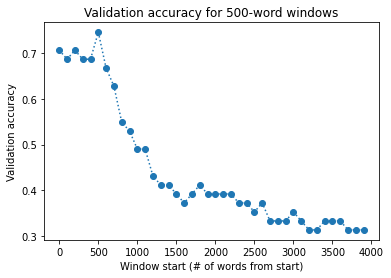

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in long_scalars


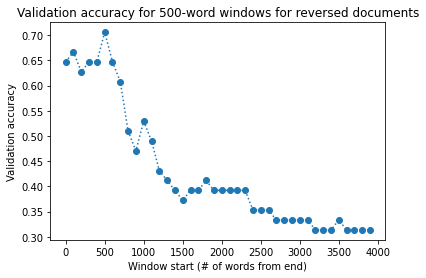

-----------------------------------------------------
judgment
              precision    recall  f1-score   support

           0       0.62      0.67      0.64        12
           1       0.64      0.58      0.61        12

    accuracy                           0.62        24
   macro avg       0.63      0.62      0.62        24
weighted avg       0.63      0.62      0.62        24

[[8 4]
 [5 7]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in long_scalars


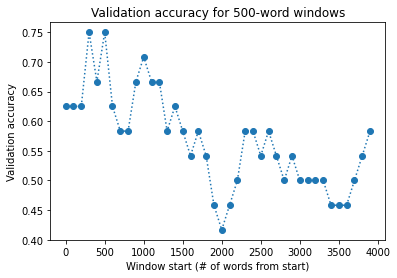

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in long_scalars


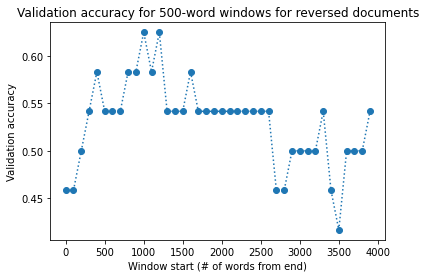

-----------------------------------------------------
ruling
              precision    recall  f1-score   support

           0       0.67      0.50      0.57         4
           1       0.00      0.00      0.00         1

    accuracy                           0.40         5
   macro avg       0.33      0.25      0.29         5
weighted avg       0.53      0.40      0.46         5

[[2 2]
 [1 0]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in long_scalars


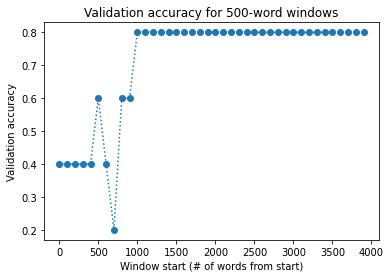

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in long_scalars


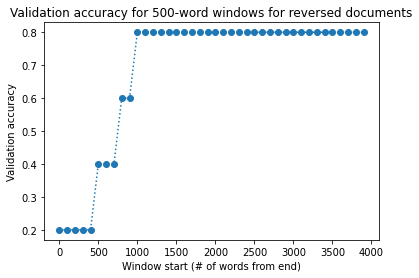

-----------------------------------------------------
decision
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           1       0.00      0.00      0.00       0.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0

[[0 1]
 [0 0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in long_scalars


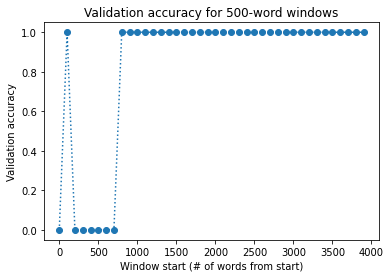

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in long_scalars


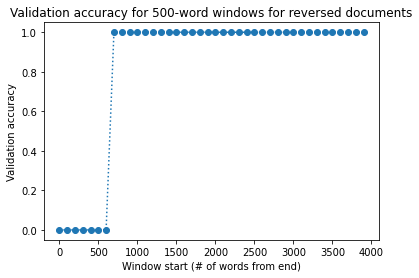

In [10]:
for doc_type in val_data.doc_type.unique():
    subset = list(val_data.cleaned_contents[val_data.doc_type == doc_type])
    y_hat = np.array(predictor.predict(subset), dtype='int64')
    y = list(val_data.Discrimination_Label[val_data.doc_type == doc_type])
    print('-----------------------------------------------------')
    print(doc_type)
    print(classification_report(y, y_hat))
    print(confusion_matrix(y, y_hat))
    
    WINDOW = 500
    accuracy = []
    F1 = []
    x = []

    for i in range(40):
        cut_start = i * 100
        cut_stop = cut_start + WINDOW
        window_data = [' '.join(i.split(' ')[cut_start:cut_stop]) for i in subset]
        window_y_hat = np.array(predictor.predict(window_data), dtype='int64')
        accuracy.append((window_y_hat == y).sum() / len(y))
        TP = ((window_y_hat == 1) & (y == 1)).sum()
        FP = ((window_y_hat == 1) & (y == 0)).sum()
        FN = ((window_y_hat == 0) & (y == 1)).sum()
        F1.append(2 * TP / (2 * TP + FP + FN))
        x.append(cut_start)
        
    plt.plot(x, np.array(accuracy), marker='o', linestyle=':')
    plt.ylabel('Validation accuracy')
    plt.xlabel('Window start (# of words from start)')
    plt.title('Validation accuracy for 500-word windows')
    plt.show()
    plt.close()
    
    accuracy = []
    F1 = []
    x = []
    
    for i in range(40):
        cut_start = i * 100
        cut_stop = cut_start + WINDOW
        window_data = [' '.join(i[::-1].split(' ')[cut_start:cut_stop]) for i in subset]
        window_y_hat = np.array(predictor.predict(window_data), dtype='int64')
        accuracy.append((window_y_hat == y).sum() / len(y))
        TP = ((window_y_hat == 1) & (y == 1)).sum()
        FP = ((window_y_hat == 1) & (y == 0)).sum()
        FN = ((window_y_hat == 0) & (y == 1)).sum()
        F1.append(2 * TP / (2 * TP + FP + FN))
        x.append(cut_start)
    
    plt.plot(x, np.array(accuracy), marker='o', linestyle=':')
    plt.ylabel('Validation accuracy')
    plt.xlabel('Window start (# of words from end)')
    plt.title('Validation accuracy for 500-word windows for reversed documents')
    plt.show()

In [11]:
test_data = pd.read_csv('../data/test_80_10_10.csv')

In [12]:
doc_type = [i.split('\n')[0] for i in test_data.cleaned_contents]
doc_type_clean = [doc.split(' ')[0].lower() for doc in doc_type]
test_data['doc_type'] = doc_type_clean
test_data.doc_type[val_data.doc_type == 'judgement'] = 'judgment'
test_data.doc_type[test_data.doc_type == 'j'] = 'judgment'
test_data.doc_type[test_data.doc_type == 's'] = 'sentence'
test_data['length'] = np.array([len(i.split(' ')) for i in test_data.cleaned_contents], dtype='int64')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
test_data.doc_type.unique()

array(['sentence', 'judgment', 'order', 'ruling', 'decision'],
      dtype=object)

In [14]:
for doc_type in test_data.doc_type.unique():
    subset = list(test_data.cleaned_contents[test_data.doc_type == doc_type])
    
    if doc_type == 'sentence':
        cut_subset = [' '.join(i.split(' ')[:500]) for i in subset]
    elif doc_type == 'judgment':
        cut_subset = [' '.join(i.split(' ')[300:800]) for i in subset]
    elif doc_type == 'ruling':
        cut_subset = [' '.join(i.split(' ')[2000:2500]) for i in subset]
    elif doc_type == 'decision':
        cut_subset = [' '.join(i.split(' ')[2000:2500]) for i in subset]
    else:
        cut_subset = [' '.join(i.split(' ')[:5000]) for i in subset]
        
    y_hat = np.array(predictor.predict(cut_subset), dtype='int64')
    y = list(test_data.Discrimination_Label[test_data.doc_type == doc_type])
    print('-----------------------------------------------------')
    print(doc_type)
    print(classification_report(y, y_hat))
    print(confusion_matrix(y, y_hat))

-----------------------------------------------------
sentence
              precision    recall  f1-score   support

           0       0.40      0.12      0.18        17
           1       0.71      0.92      0.80        39

    accuracy                           0.68        56
   macro avg       0.55      0.52      0.49        56
weighted avg       0.61      0.68      0.61        56

[[ 2 15]
 [ 3 36]]
-----------------------------------------------------
judgment
              precision    recall  f1-score   support

           0       0.80      0.33      0.47        12
           1       0.33      0.80      0.47         5

    accuracy                           0.47        17
   macro avg       0.57      0.57      0.47        17
weighted avg       0.66      0.47      0.47        17

[[4 8]
 [1 4]]
-----------------------------------------------------
order
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [15]:
len(cut_subset)

1

In [16]:
len(y_hat)

1

In [17]:
y = list(test_data.Discrimination_Label[test_data.doc_type == doc_type])

In [18]:
len(y)

1

In [19]:
np.array(test_data.doc_type == 'sentence').sum()

56

In [20]:
y_hat = np.array(predictor.predict(list(test_data.cleaned_contents)), dtype='int64')

In [21]:
y = np.array(test_data.Discrimination_Label, dtype='int64')

In [22]:
print(classification_report(y, y_hat))

              precision    recall  f1-score   support

           0       0.83      0.51      0.63        37
           1       0.69      0.91      0.78        44

    accuracy                           0.73        81
   macro avg       0.76      0.71      0.71        81
weighted avg       0.75      0.73      0.72        81



In [23]:
val_data

,Unnamed: 0,docid,cleaned_contents,Discrimination_Label,Customary_Practices,Gender_Stereotypes,Other_Factors,Num_Factors,doc_type,length
0,647,73659,SENTENCE\n\n\t1.\tThe Director of Public Prose...,0,0,0,0,0,sentence,1817
1,648,249010,SENTENCE\n \n \n• In a judgment delivered yes...,1,0,0,1,1,sentence,2398
2,649,269632,JUDGMENT\n \n \nGates P:\n \n \n1. I agree wit...,1,0,1,0,1,judgment,4255
3,650,251896,JUDGMENT\n \n \n INTRODUCTION\n \n \n• The Ap...,0,0,0,0,0,judgment,6373
4,651,71037,JUDGMENT\n\nThe Appellant was convicted in the...,1,0,1,0,1,judgment,4844
...,...,...,...,...,...,...,...,...,...,...
76,723,71573,SENTENCE\n\n\t1.\tThe accused has been convict...,0,0,0,0,0,sentence,428
77,724,80901,JUDGMENT\n\n[1] This is an appeal against sent...,1,1,1,0,2,judgment,609
78,725,74223,SENTENCE\n\n[1] On the 19th July in this Court...,0,0,0,0,0,sentence,814
79,726,260460,SENTENCE\n \n \n[Name of the victim is suppres...,1,0,1,0,1,sentence,588


In [24]:
train_data = pd.read_csv('../data/train_80_10_10.csv')

In [25]:
doc_type = [i.split('\n')[0] for i in train_data.cleaned_contents]
doc_type_clean = [doc.split(' ')[0].lower() for doc in doc_type]
train_data['doc_type'] = doc_type_clean
train_data.doc_type[train_data.doc_type == 'judgement'] = 'judgment'
train_data.doc_type[train_data.doc_type == 'j'] = 'judgment'
train_data.doc_type[train_data.doc_type == 's'] = 'sentence'
train_data.doc_type[train_data.doc_type == 'r'] = 'ruling'
train_data.doc_type[train_data.doc_type == 'sentence:'] = 'sentence'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: Se

In [26]:
train_data.head()

,Unnamed: 0,docid,cleaned_contents,Discrimination_Label,Customary_Practices,Gender_Stereotypes,Other_Factors,Num_Factors,doc_type
0,0,255849,SENTENCE\n \n \n• In a judgment delivered on ...,0,0,0,0,0,sentence
1,1,288617,"SENTENCE\n \n• ELIZABETH GOLMAN, you were cha...",1,0,0,1,1,sentence
2,2,78029,SENTENCE\n\n\t1.\tThe accused is before the Co...,1,0,1,0,1,sentence
3,3,255988,SENTENCE\n \n_________________________________...,0,0,0,0,0,sentence
4,4,81960,SENTENCE\n\n1. The Director of Public Prosecut...,1,1,1,0,2,sentence


In [27]:
train_data.doc_type.unique()

array(['sentence', 'judgment', 'ruling', 'decision', 'application'],
      dtype=object)

In [28]:
train_data['length'] = np.array([len(i.split(' ')) for i in train_data.cleaned_contents], dtype='int64')

In [29]:
train_data.head()

,Unnamed: 0,docid,cleaned_contents,Discrimination_Label,Customary_Practices,Gender_Stereotypes,Other_Factors,Num_Factors,doc_type,length
0,0,255849,SENTENCE\n \n \n• In a judgment delivered on ...,0,0,0,0,0,sentence,731
1,1,288617,"SENTENCE\n \n• ELIZABETH GOLMAN, you were cha...",1,0,0,1,1,sentence,594
2,2,78029,SENTENCE\n\n\t1.\tThe accused is before the Co...,1,0,1,0,1,sentence,1257
3,3,255988,SENTENCE\n \n_________________________________...,0,0,0,0,0,sentence,904
4,4,81960,SENTENCE\n\n1. The Director of Public Prosecut...,1,1,1,0,2,sentence,911


In [30]:
import seaborn as sns

In [31]:
sns.set(style="ticks")
pal = {day: "b" for day in tips.day.unique()}

NameError: name 'tips' is not defined

In [ ]:
plt.figure(figsize=(10,10))
sns.boxplot(x="doc_type", y="length",
            data=train_data, xlabel='Length (word)')

In [33]:
train_data.to_csv('../data/train_80_10_10_doc_type.csv')
val_data.to_csv('../data/val_80_10_10_doc_type.csv')
test_data.to_csv('../data/test_80_10_10_doc_type.csv')